In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.13.0+cu116


In [ ]:
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric import nn
import torch_geometric.transforms as T

In [ ]:
import json
import pandas as pd
import numpy as np
proj_dir = os.path.join("/content/drive/MyDrive/FinalProject")

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
f = open(os.path.join(proj_dir,"Processed_Data","graph","node2id.json"))
node2id = json.load(f)

f = open(os.path.join(proj_dir,"Processed_Data","graph","id2node.json"))
id2node = json.load(f)

In [ ]:
a = [(item[0], item[1]) for item in id2node.items()]

In [ ]:
len(a)

10532

In [ ]:
relation = ["mm","dd","gg","md","mg","dg"]

In [ ]:
pth = "/content/drive/MyDrive/FinalProject/Processed_Data/graph/{}_edge.csv".format("gg")
edge_df = pd.read_csv(pth)
edge_list = np.transpose(edge_df.values)

In [ ]:
edge_index = {}
for rel in relation:
  pth = "/content/drive/MyDrive/FinalProject/Processed_Data/graph/{}_edge.csv".format(rel)
  edge_df = pd.read_csv(pth)
  edge_list = np.transpose(edge_df.values)
  edge_index[rel] = torch.tensor(edge_list).long()

In [ ]:
edge_index

{'mm': tensor([[ 311,  311,  311,  ...,  600,  890,  890],
         [ 483,  710,  852,  ...,  486, 1052,   36]]),
 'dd': tensor([[ 311,  311,  311,  ...,  600,  890,  890],
         [ 483,  710,  852,  ...,  486, 1052,   36]]),
 'gg': tensor([[8182, 8182, 8182,  ..., 6272, 4574, 5367],
         [3066, 5661, 5830,  ..., 1894, 1894, 1894]]),
 'md': array([[ 311,  311,  311, ...,  665,   36,  600],
        [ 852,   38,  449, ...,  145, 1052,  486]]),
 'mg': tensor([[ 120,  360,  360,  ...,  338,  338,   75],
         [4281, 4696, 4696,  ..., 2884, 6833, 7093]]),
 'dg': tensor([[5925, 5925, 4194,  ..., 7342, 5467, 5467],
         [1183, 1153, 1153,  ..., 1204, 1131, 1148]])}

# 新段落

In [ ]:
1109,113, 9311

(1109, 113, 9311)

In [ ]:
node_list = node2id.values()

In [ ]:
len(node_list)

10532

In [ ]:
from torch_geometric.data import Data
y = [1 for i in range(edge_index["md"].shape[0])]
data = Data(x=node_list, edge_index=edge_index["md"], y=y)

In [ ]:
num_training_data =  edge_index["md"].shape[1]
x = edge_index["md"]

In [ ]:

import torch.utils.data as data
torch.manual_seed(0)
train_set_size = int(num_training_data* 0.75)
valid_set_size = int(num_training_data *0.05)
test_set_size = num_training_data - train_set_size - valid_set_size

index_list = np.arange(0,num_training_data,1)

np.random.shuffle(index_list)
training_data_index = index_list[:train_set_size]
validation_data_index  = index_list[train_set_size:train_set_size+valid_set_size]
testing_data_index = index_list[train_set_size+valid_set_size:]

train_x = []
train_y = []

valid_x = []
valid_y = []

test_x = []
test_y = []

#create training data
for idx in training_data_index:
  train_x.append([x[0][idx],x[1][idx]])
  train_y.append(1)
#create training data
for idx in validation_data_index:
  valid_x.append([x[0][idx],x[1][idx]])
  valid_y.append(1)
#create training data
for idx in testing_data_index:
  test_x.append([x[0][idx],x[1][idx]])
  test_y.append(1)

print("{} training data, {} validation data, {} testing data".\
  format(len(train_x), len(valid_x),len(test_x)))

train_mask = [0]*num_training_data
for i in training_data_index:
  train_mask[i] = 1


valid_mask = [0]*num_training_data
for i in validation_data_index:
  valid_mask[i] = 1

test_mask = [0]*num_training_data
for i in testing_data_index:
  test_mask[i] = 1

259967 training data, 17331 validation data, 69325 testing data


In [ ]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, num_node, E_dim, edge_list, relations, hidden_channels, out_channels):
        super().__init__()

        self.E = torch.rand(num_node, E_dim)
        self.edges = edge_list
        self.relarions = relations
        self.num_relarion = len(self.relarions)

        self.conv1 = [GCNConv(E_dim, hidden_channels) for i in range(self.num_relarion)]
        self.transform1 = torch.nn.Linear(hidden_channels*6,hidden_channels)
        self.conv2 = [GCNConv(hidden_channels, hidden_channels) for i in range(self.num_relarion)]
        self.transform2 = torch.nn.Linear(hidden_channels*6,out_channels)
        self.act = torch.nn.ReLU()

        self.ff1 = torch.nn.Linear(out_channels*2,32)
        self.ff2 = torch.nn.Linear(32,1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self,edge_list):
        out1 = []
        for i,rel in enumerate(self.relarions):
          out1.append(self.conv1[i](self.E, edge_list[rel]))

        out = torch.cat(out1, 1)
        out = self.transform1(out)

        out = self.act(out)

        out2 = []
        for i,rel in enumerate(self.relarions):
          out2.append(self.conv2[i](out, self.edges[rel]))

        out = torch.cat(out2, 1)
        out = self.transform2(out)

        return out

    def classifier1(self, node_pair):

        node1 = node_pair[0]
        node2 = node_pair[1]
        x =  torch.cat((node1,node2))

        x = self.ff1(x)
        x = self.ff2(x)
        output = self.sigmoid(x)

        return output

    def classifier2(self, node_pairs):
        node1 = self.E[node_pair[0]]
        node2 = self.E[node_pair[1]]

        x =  torch.cat((node1,node2))
        x = self.ff1(x)
        x = self.ff2(x)
        # output = self.sigmoid(x)

        return output

In [ ]:
model = GCN(len(node_list), \
            E_dim = 8, \
            edge_list =edge_index, \
            relations = relation,  \
            hidden_channels=128, \
            out_channels=64)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
loss_fn = torch.nn.BCEWithLogitsLoss()

In [ ]:
all_edges = np.column_stack((edge_index["mm"], edge_index["dd"],edge_index["gg"],\
                             edge_index["md"],edge_index["mg"],edge_index["dg"]))

In [ ]:
all_edges

array([[ 311,  311,  311, ..., 7342, 5467, 5467],
       [ 483,  710,  852, ..., 1204, 1131, 1148]])

In [ ]:
len(all_edges[0])

1594438

negtive sampling

In [ ]:
import random

num_neg = 500000
neg_edge_index =  []
edge_trans = np.transpose(edge_index["mg"])
while len(neg_edge_index) < num_neg:
  m = random.randint(0, 1109)
  d = random.randint(1109, 1222)

  if torch.tensor([m,d]) not in edge_trans:
    neg_edge_index.append([m,d])

print("numer of neg_edge_index:", len(neg_edge_index))  # [2, num_neg_samples]
print("negative examples:", neg_edge_index)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
from tqdm import tqdm
from torch.autograd import Variable
def train2(model, data, neg_edge_index, optimizer, loss_fn, train_mask):
  loss = 0
  model.train()
  optimizer.zero_grad()

  node_embs = model(data)

  y_pred = []

  data = np.column_stack((data["mm"], data["dd"],data["gg"],\
                             data["md"],data["mg"],data["dg"]))
  neg_edge_index = torch.tensor(neg_edge_index)

  data = torch.tensor(data)
  print(data.shape)
  print(neg_edge_index.shape)
  data = np.transpose(data)
  all_data = torch.cat((data,neg_edge_index),0)
  all_labels = torch.tensor([1]*len(data)+[0]*len(neg_edge_index))
  for idx, pair in enumerate(tqdm(all_data)):
      pair_embed = (node_embs[pair[0]],node_embs[pair[1]])
      y_pred.append(model.classifier1(pair_embed))


  # y_pred = Variable(y_pred, requires_grad=True)
  # print(y_pred.shape)

  y_pred = torch.tensor(y_pred)
  loss = loss_fn(y_pred,all_labels.float())
  # loss = torch.tensor(loss)

  # outputs.clone().detach()
  loss = Variable(loss, requires_grad=True)
  loss.backward()
  optimizer.step()

  return loss



In [ ]:
edge_index_masked = edge_index
edge_index_md = edge_index_masked["md"]
edge_index_md_train_masked = list(zip(np.transpose(edge_index_md),train_mask))
edge_index_md_valid_masked = list(zip(np.transpose(edge_index_md),valid_mask))
edge_index_md_test_masked= list(zip(np.transpose(edge_index_md),test_mask))

edge_index_md_train_masked = [x[0].tolist() for x in edge_index_md_train_masked if x[1] == 1]
edge_index_md_valid_masked = [x[0].tolist() for x in edge_index_md_valid_masked if x[1] == 1]
edge_index_md_test_masked = [x[0].tolist() for x in edge_index_md_test_masked if x[1] == 1]

In [ ]:
edge_index_train = edge_index_masked
edge_index_train["md"] = torch.tensor(np.transpose(edge_index_md_train_masked))

edge_index_valid = edge_index_masked
edge_index_valid["md"] = torch.tensor(np.transpose(edge_index_md_valid_masked))

edge_index_test = edge_index_masked
edge_index_test["md"] = torch.tensor(np.transpose(edge_index_md_test_masked))

In [ ]:
from sklearn.metrics import accuracy_score

@torch.no_grad()
def test(model, data):
    model.eval()
    out = model(data)

    data = data["md"]
    data = np.transpose(data)
    y_pred = []
    for idx, pair in enumerate(tqdm(data)):
      pair_embed = (out[pair[0]],out[pair[1]])
      y_pred.append(model.classifier1(pair_embed))
    y_pred = [1 if y>0.5 else 0 for y in y_pred]

    return accuracy_score([1]*len(y_pred), y_pred)
epochs = 50

best_val_accu = final_test_accu = 0
for epoch in range(1, epochs + 1):
    loss = train2(model, edge_index_train, neg_edge_index, optimizer, loss_fn,train_mask)
    valid_accu = test(model, edge_index_valid)
    test_accu = test(model, edge_index_test)
    if valid_accu > best_val_accu:
        best_val_accu = valid_accu
        final_test_accu = test_accu
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {valid_accu:.4f}, Test: {test_accu:.4f}')

torch.Size([2, 1317140])
torch.Size([50000, 2])


 55%|█████▌    | 756717/1367140 [02:20<3:21:54, 50.39it/s]

In [ ]:
edge_index_train

In [ ]:
sum(train_mask)

In [ ]:
from tqdm import tqdm
from torch.autograd import Variable
# train with all class of relations
def train(model, data, neg_edge_index, optimizer, loss_fn, train_mask):
  loss = 0
  model.train()
  optimizer.zero_grad()

  node_embs = model(data)

  y_pred = []

  neg_edge_index = torch.tensor(neg_edge_index)

  data = data["md"]
  data = np.transpose(data)


  all_data = torch.cat((data,neg_edge_index),0)
  all_labels = torch.tensor([1]*len(data)+[0]*len(neg_edge_index))
  #for test purpose, comment out after
  # all_data = all_data[:10]
  # all_labels = all_labels[:10]
  # for idx, pair in tqdm(enumerate(all_data)):
  #     pair_embed = (node_embs[pair[0]],node_embs[pair[1]])
  #     y_pred.append(model.classifier1(pair_embed))
  for idx, pair in enumerate(tqdm(all_data)):
      pair_embed = (node_embs[pair[0]],node_embs[pair[1]])
      y_pred.append(model.classifier1(pair_embed))


  # y_pred = Variable(y_pred, requires_grad=True)
  # print(y_pred.shape)

  y_pred = torch.tensor(y_pred)
  loss = loss_fn(y_pred,all_labels.float())
  # loss = torch.tensor(loss)
  # outputs.clone().detach()
  loss = Variable(loss, requires_grad=True)
  loss.backward()
  optimizer.step()

  return loss



In [ ]:
node_features = torch.rand(len(node_list),dtype=torch.double)
node_features = torch.unsqueeze(node_features, dim=-1).double()


node_features


tensor([[0.6969],
        [0.6318],
        [0.3463],
        ...,
        [0.3314],
        [0.3298],
        [0.7214]], dtype=torch.float64)

In [ ]:
node_features = torch.from_numpy(np.random.randint(100, size = (len(node_list),1) )).float()

In [ ]:
node_features.shape

torch.Size([10532, 1])

In [ ]:
from torch_geometric.nn import GCNConv

class GCN_RandFeature(torch.nn.Module):
    def __init__(self, num_node, edge_list, relations, hidden_channels, out_channels):
        super().__init__()

        # self.E = torch.rand(num_node, E_dim)
        self.edges = edge_list
        self.relarions = relations
        self.num_relarion = len(self.relarions)

        self.conv1 = [GCNConv(1, hidden_channels) for i in range(self.num_relarion)]
        self.transform1 = torch.nn.Linear(hidden_channels*6,hidden_channels)
        self.conv2 = [GCNConv(hidden_channels, hidden_channels) for i in range(self.num_relarion)]
        self.transform2 = torch.nn.Linear(hidden_channels*6,out_channels)
        self.act = torch.nn.ReLU()

        self.ff1 = torch.nn.Linear(out_channels*2,32)
        self.ff2 = torch.nn.Linear(32,1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self,edge_list,node_features):
        out1 = []
        for i,rel in enumerate(self.relarions):
          out1.append(self.conv1[i](node_features, edge_list[rel]))

        out = torch.cat(out1, 1)
        out = self.transform1(out)

        out = self.act(out)

        out2 = []
        for i,rel in enumerate(self.relarions):
          out2.append(self.conv2[i](out, self.edges[rel]))

        out = torch.cat(out2, 1)
        out = self.transform2(out)

        return out

    def classifier1(self, node_pair):

        node1 = node_pair[0]
        node2 = node_pair[1]
        x =  torch.cat((node1,node2))

        x = self.ff1(x)
        x = self.ff2(x)
        output = self.sigmoid(x)

        return output

    def classifier2(self, node_pairs):
        node1 = self.E[node_pair[0]]
        node2 = self.E[node_pair[1]]

        x =  torch.cat((node1,node2))
        x = self.ff1(x)
        x = self.ff2(x)
        output = self.sigmoid(x)

        return output

from tqdm import tqdm
from torch.autograd import Variable
# train with all class of relations
def train2(model, data, node_features, neg_edge_index, optimizer, loss_fn,train_mask):
  loss = 0
  model.train()
  optimizer.zero_grad()

  node_embs = model(data,node_features)

  y_pred = []


  neg_edge_index = torch.tensor(neg_edge_index)

  data = data["md"]
  data = np.transpose(data)


  all_data = torch.cat((data,neg_edge_index),0)
  all_labels = torch.tensor([1]*len(data)+[0]*len(neg_edge_index))
  #for test purpose, comment out after
  # all_data = all_data[:10]
  # all_labels = all_labels[:10]
  # for idx, pair in tqdm(enumerate(all_data)):
  #     pair_embed = (node_embs[pair[0]],node_embs[pair[1]])
  #     y_pred.append(model.classifier1(pair_embed))
  for idx, pair in enumerate(tqdm(all_data)):
      pair_embed = (node_embs[pair[0]],node_embs[pair[1]])
      y_pred.append(model.classifier1(pair_embed))


  # y_pred = Variable(y_pred, requires_grad=True)
  # print(y_pred.shape)

  y_pred = torch.tensor(y_pred)
  loss = loss_fn(y_pred,all_labels.float())
  # loss = torch.tensor(loss)
  # outputs.clone().detach()
  loss = Variable(loss, requires_grad=True)
  loss.backward()
  optimizer.step()

  return loss

from sklearn.metrics import accuracy_score

@torch.no_grad()
def test2(model, data,node_features):
    model.eval()
    out = model(data,node_features)

    data = data["md"]
    data = np.transpose(data)
    y_pred = []
    for idx, pair in enumerate(tqdm(data)):
      pair_embed = (out[pair[0]],out[pair[1]])
      y_pred.append(model.classifier1(pair_embed))
    y_pred = [1 if y>0.5 else 0 for y in y_pred]

    return accuracy_score([1]*len(y_pred), y_pred)
model = GCN_RandFeature(len(node_list), \
            edge_list =edge_index, \
            relations = relation,  \
            hidden_channels=128, \
            out_channels=64)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
loss_fn = torch.nn.BCEWithLogitsLoss()

epochs = 10

best_val_accu = final_test_accu = 0
for epoch in range(1, epochs + 1):
    loss = train2(model, edge_index_train, node_features,neg_edge_index, optimizer, loss_fn, train_mask)
    valid_accu = test2(model, edge_index_valid,node_features)
    test_accu = test2(model, edge_index_test,node_features)
    if valid_accu > best_val_accu:
        best_val_accu = valid_accu
        final_test_accu = test_accu
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {valid_accu:.4f}, Test: {test_accu:.4f}')

100%|██████████| 69325/69325 [00:05<00:00, 13598.03it/s]


Epoch: 001, Loss: 0.7445, Val: 0.0016, Test: 0.0016


100%|██████████| 69325/69325 [00:04<00:00, 14963.21it/s]


Epoch: 002, Loss: 0.7445, Val: 0.0016, Test: 0.0016


  3%|▎         | 3819/119325 [00:00<00:29, 3952.03it/s]


KeyboardInterrupt: ignored

In [ ]:
node_feature_onehot = torch.zeros((len(node_list),3))
# 0-1691
#1692 - 1803
for i in range(node_feature_onehot.shape[0]):
  if i <=1691:
    node_feature_onehot[i][0] = 1
  elif i <=1803:
    node_feature_onehot[i][1] = 1
  else:
    node_feature_onehot[i][2] = 1

In [ ]:
len(node_list)-1803

8729

In [ ]:
node_feature_onehot.shape

torch.Size([10532, 3])

In [ ]:
from operator import add
valid_mask2 = list( map(add, train_mask, valid_mask) )

In [ ]:
np.transpose(edge_index_md_train_masked)

array([[ 311,  311,  311, ...,   36,  890,  890],
       [ 483,  710,  514, ...,  890, 1052,   36]])

In [ ]:
edge_index_masked = edge_index
edge_index_md = edge_index_masked["md"]
edge_index_md_train_masked = list(zip(np.transpose(edge_index_md),train_mask))
edge_index_md_valid_masked = list(zip(np.transpose(edge_index_md),valid_mask2))
edge_index_md_test_masked= list(zip(np.transpose(edge_index_md),[1]*len(edge_index_md[0])))

edge_index_md_train_masked = np.transpose([x[0].tolist() for x in edge_index_md_train_masked if x[1] == 1])
edge_index_md_valid_masked = np.transpose([x[0].tolist() for x in edge_index_md_valid_masked if x[1] == 1])
edge_index_md_test_masked = np.transpose([x[0].tolist() for x in edge_index_md_test_masked if x[1] == 1])

all_edges = np.column_stack((edge_index["mm"], edge_index["dd"],edge_index["gg"],\
                             edge_index["md"],edge_index["mg"],edge_index["dg"]))

all_edges_train_dict = edge_index_masked
all_edges_valid_dict = edge_index_masked
all_edges_test_dict = edge_index_masked

all_edges_train_dict["md"] = edge_index_md_train_masked
all_edges_valid_dict["md"] = edge_index_md_valid_masked
all_edges_test_dict["md"] = edge_index_md_test_masked


all_edges_train = np.column_stack((edge_index_masked["mm"], edge_index_masked["dd"],edge_index_masked["gg"],\
                            edge_index_md_train_masked,edge_index_masked["mg"],edge_index_masked["dg"]))
all_edges_valid = np.column_stack((edge_index_masked["mm"], edge_index_masked["dd"],edge_index_masked["gg"],\
                             edge_index_md_valid_masked,edge_index_masked["mg"],edge_index_masked["dg"]))
all_edges_test = all_edges

In [ ]:
neg_edge_index

[[775, 1140],
 [106, 1129],
 [756, 1190],
 [806, 1131],
 [190, 1127],
 [754, 1212],
 [27, 1149],
 [27, 1159],
 [48, 1164],
 [754, 1205],
 [1071, 1153],
 [259, 1215],
 [1038, 1124],
 [372, 1143],
 [834, 1122],
 [873, 1146],
 [860, 1196],
 [596, 1157],
 [1038, 1159],
 [493, 1174],
 [183, 1159],
 [883, 1115],
 [79, 1209],
 [27, 1140],
 [172, 1141],
 [656, 1121],
 [388, 1175],
 [259, 1158],
 [373, 1207],
 [742, 1195],
 [567, 1193],
 [1065, 1188],
 [1047, 1137],
 [534, 1164],
 [434, 1137],
 [173, 1159],
 [149, 1148],
 [173, 1178],
 [1107, 1203],
 [705, 1157],
 [106, 1209],
 [468, 1220],
 [378, 1175],
 [539, 1134],
 [615, 1180],
 [1047, 1118],
 [688, 1193],
 [714, 1174],
 [372, 1125],
 [112, 1218],
 [183, 1109],
 [673, 1191],
 [112, 1124],
 [210, 1133],
 [904, 1156],
 [929, 1222],
 [175, 1214],
 [534, 1220],
 [1022, 1204],
 [904, 1162],
 [174, 1201],
 [378, 1189],
 [801, 1218],
 [501, 1140],
 [809, 1110],
 [106, 1213],
 [569, 1133],
 [956, 1145],
 [656, 1209],
 [69, 1141],
 [931, 1211],
 [37

In [ ]:
def compute_similarity(node_embs, edge_index):
    result = 0
    result = (node_embs[edge_index[0]] * node_embs[edge_index[1]]).sum(dim=-1)

    return result

In [ ]:
from torch_geometric.nn import GCNConv

class GCN_RandFeatureOneHot(torch.nn.Module):
    def __init__(self, num_node, edge_list, in_channels, hidden_channels, out_channels):
        super().__init__()

        # self.E = torch.rand(num_node, E_dim)

        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels) # num_node * out_channels
        self.act = torch.nn.ReLU()

        self.ff1 = torch.nn.Linear(out_channels*2,32)
        self.ff2 = torch.nn.Linear(32,1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self,edge_list,node_features, train_edge_list):

        out = self.conv1(x = node_features, edge_index = edge_list)

        out = self.act(out)
        out = self.conv2(x = out, edge_index = edge_list)


        return out




In [ ]:

from tqdm import tqdm
from torch.autograd import Variable
# train with all class of relations
def train_GCN_RandFeatureOneHot(model, data, node_feature_onehot, neg_edge_index, optimizer, loss_fn,train_mask):
  loss = 0
  model.to(device)
  model.train()
  optimizer.zero_grad()



  train_edge = torch.tensor(data["md"]).to(device)

  all_edge = torch.tensor(np.column_stack((data["mm"], data["dd"],data["gg"],\
                             data["md"],data["mg"],data["dg"]))).to(device)


  neg_edge_index = torch.tensor(np.transpose(neg_edge_index))
  all_data = torch.cat((train_edge,neg_edge_index),1).to(device)
  node_feature_onehot = node_feature_onehot.to(device)
  all_labels = torch.tensor([1]*len(train_edge[0])+[0]*len(neg_edge_index[0])).to(device)

  out = model(all_edge,node_feature_onehot,all_data)

  similarity = compute_similarity(out,all_data)

  loss = loss_fn(similarity,all_labels.float())
  loss.backward()
  # for name, param in model.named_parameters():
  #   print(name, param.grad)
  optimizer.step()

  return loss


In [ ]:
def plot_train_valid_loss(epochs,train_loss,valid_loss):
  epoch = list(range(epochs))
  # plotting the line 1 points
  plt.plot(epoch, train_loss, label = "train")
  plt.plot(epoch, valid_loss, label = "valid")

  # naming the x axis
  plt.xlabel('epochs')
  # naming the y axis
  plt.ylabel('loss')
  # giving a title to my graph
  plt.title('train valid loss')
  # show a legend on the plot
  plt.legend()
  plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

@torch.no_grad()
def test2(model, data,node_feature_onehot):
    model.eval()

    train_edge = torch.tensor(data["md"]).to(device)

    all_edge = torch.tensor(np.column_stack((data["mm"], data["dd"],data["gg"],\
                             data["md"],data["mg"],data["dg"]))).to(device)

    out = model(all_edge,node_feature_onehot,train_edge)

    similarity = compute_similarity(out,train_edge)
    y_pred =  []
    loss = loss_fn(similarity,torch.tensor([1]*len(train_edge[0])).float())

    sig = torch.nn.Sigmoid()
    similarity = sig(similarity.detach())
    for i in similarity:
      if i <0.5:
         y_pred.append(0)
      else:
          y_pred.append(1)
    return accuracy_score(y_pred, [1]*len(similarity)),loss



In [ ]:
model = GCN_RandFeatureOneHot(len(node_list), \
            edge_list =edge_index, \
            in_channels = 3,
            hidden_channels=128, \
            out_channels=64)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.1)
loss_fn = torch.nn.BCEWithLogitsLoss()
epochs = 10

best_val_accu = final_test_accu = 0

train_loss = []
valid_loss = []
test_loss = []

for epoch in range(1, epochs + 1):
    loss = train_GCN_RandFeatureOneHot(model, all_edges_train_dict, node_feature_onehot,neg_edge_index, optimizer, loss_fn, train_mask)
    train_loss.append(loss.detach().numpy())
    valid_accu,v_loss = test2(model, all_edges_valid_dict,node_feature_onehot)
    valid_loss.append(v_loss.detach().numpy())

    test_accu,t_loss = test2(model, all_edges_test_dict,node_feature_onehot)
    test_loss.append(t_loss.detach().numpy())
    if valid_accu > best_val_accu:
        best_val_accu = valid_accu
        final_test_accu = test_accu
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {valid_accu:.4f}, Test: {test_accu:.4f}')

Epoch: 001, Loss: 1.0641, Val: 1.0000, Test: 1.0000
Epoch: 002, Loss: 58.2330, Val: 1.0000, Test: 1.0000
Epoch: 003, Loss: 0.5272, Val: 1.0000, Test: 1.0000
Epoch: 004, Loss: 0.3702, Val: 1.0000, Test: 1.0000
Epoch: 005, Loss: 0.8213, Val: 1.0000, Test: 1.0000
Epoch: 006, Loss: 1.0749, Val: 1.0000, Test: 1.0000
Epoch: 007, Loss: 0.9399, Val: 1.0000, Test: 1.0000
Epoch: 008, Loss: 0.6764, Val: 1.0000, Test: 1.0000
Epoch: 009, Loss: 0.4790, Val: 1.0000, Test: 1.0000
Epoch: 010, Loss: 0.3408, Val: 1.0000, Test: 1.0000


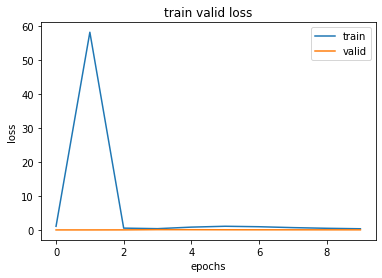

In [ ]:
plot_train_valid_loss(epochs,train_loss,valid_loss)

In [ ]:
model_923 = GCN_RandFeatureOneHot(len(node_list), \
            edge_list =edge_index, \
            in_channels = 3,
            hidden_channels=128, \
            out_channels=64)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

loss_fn = torch.nn.BCEWithLogitsLoss()
epochs = 10

best_val_accu = final_test_accu = 0

train_loss = []
valid_loss = []
test_loss = []

for epoch in range(1, epochs + 1):
    loss = train_GCN_RandFeatureOneHot(model, all_edges_train_dict, node_feature_onehot,neg_edge_index, optimizer, loss_fn, train_mask)
    train_loss.append(loss.detach().numpy())
    valid_accu,v_loss = test2(model, all_edges_valid_dict,node_feature_onehot)
    valid_loss.append(v_loss.detach().numpy())

    test_accu,t_loss = test2(model, all_edges_test_dict,node_feature_onehot)
    test_loss.append(t_loss.detach().numpy())
    if valid_accu > best_val_accu:
        best_val_accu = valid_accu
        final_test_accu = test_accu
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {valid_accu:.4f}, Test: {test_accu:.4f}')

Epoch: 001, Loss: 0.9570, Val: 0.9792, Test: 0.9792
Epoch: 002, Loss: 0.3766, Val: 0.9994, Test: 0.9994
Epoch: 003, Loss: 0.2470, Val: 1.0000, Test: 1.0000
Epoch: 004, Loss: 0.2123, Val: 1.0000, Test: 1.0000
Epoch: 005, Loss: 0.2400, Val: 1.0000, Test: 1.0000
Epoch: 006, Loss: 0.2567, Val: 1.0000, Test: 1.0000
Epoch: 007, Loss: 0.2475, Val: 1.0000, Test: 1.0000
Epoch: 008, Loss: 0.2209, Val: 1.0000, Test: 1.0000
Epoch: 009, Loss: 0.1940, Val: 1.0000, Test: 1.0000
Epoch: 010, Loss: 0.1825, Val: 0.9998, Test: 0.9998


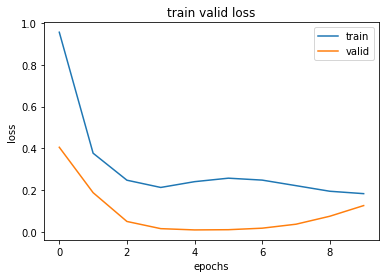

In [ ]:
plot_train_valid_loss(epochs,train_loss,valid_loss)

Epoch: 001, Loss: 1.0920, Val: 1.0000, Test: 1.0000
Epoch: 002, Loss: 45.0169, Val: 1.0000, Test: 1.0000
Epoch: 003, Loss: 0.5645, Val: 1.0000, Test: 1.0000
Epoch: 004, Loss: 0.3032, Val: 1.0000, Test: 1.0000
Epoch: 005, Loss: 0.5362, Val: 1.0000, Test: 1.0000
Epoch: 006, Loss: 0.5477, Val: 1.0000, Test: 1.0000
Epoch: 007, Loss: 0.4528, Val: 1.0000, Test: 1.0000
Epoch: 008, Loss: 0.3742, Val: 1.0000, Test: 1.0000
Epoch: 009, Loss: 0.3272, Val: 1.0000, Test: 1.0000
Epoch: 010, Loss: 0.2990, Val: 1.0000, Test: 1.0000


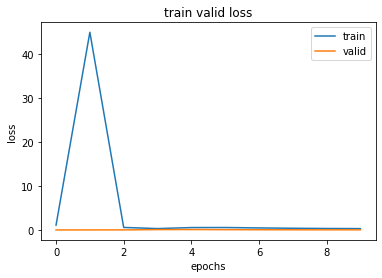

In [ ]:
model = GCN_RandFeatureOneHot(len(node_list), \
            edge_list =edge_index, \
            in_channels = 3,
            hidden_channels=128, \
            out_channels=64)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.1)

from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
loss_fn = torch.nn.BCEWithLogitsLoss()
epochs = 10

best_val_accu = final_test_accu = 0


train_loss = []
valid_loss = []
test_loss = []

for epoch in range(1, epochs + 1):
    loss = train_GCN_RandFeatureOneHot(model, all_edges_train_dict, node_feature_onehot,neg_edge_index, optimizer, loss_fn, train_mask)
    train_loss.append(loss.detach().numpy())
    valid_accu,v_loss = test2(model, all_edges_valid_dict,node_feature_onehot)
    valid_loss.append(v_loss.detach().numpy())
    scheduler.step()
    test_accu,t_loss = test2(model, all_edges_test_dict,node_feature_onehot)
    test_loss.append(t_loss.detach().numpy())
    if valid_accu > best_val_accu:
        best_val_accu = valid_accu
        final_test_accu = test_accu
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {valid_accu:.4f}, Test: {test_accu:.4f}')

plot_train_valid_loss(epochs,train_loss,valid_loss)

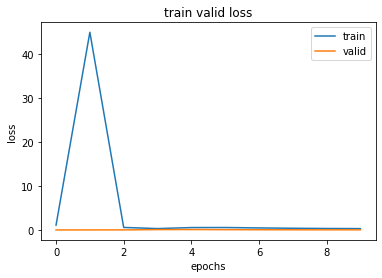

In [ ]:
plot_train_valid_loss(epochs,train_loss,valid_loss)

Epoch: 001, Loss: 0.9441, Val: 0.9856, Test: 0.9856
Epoch: 002, Loss: 0.3541, Val: 0.9995, Test: 0.9995
Epoch: 003, Loss: 0.2271, Val: 1.0000, Test: 1.0000
Epoch: 004, Loss: 0.2044, Val: 1.0000, Test: 1.0000
Epoch: 005, Loss: 0.2424, Val: 1.0000, Test: 1.0000
Epoch: 006, Loss: 0.2678, Val: 1.0000, Test: 1.0000
Epoch: 007, Loss: 0.2649, Val: 1.0000, Test: 1.0000
Epoch: 008, Loss: 0.2397, Val: 1.0000, Test: 1.0000
Epoch: 009, Loss: 0.2073, Val: 1.0000, Test: 1.0000
Epoch: 010, Loss: 0.1850, Val: 0.9999, Test: 0.9999


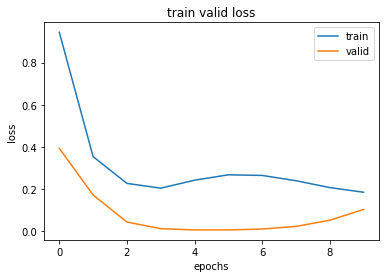

In [ ]:
model = GCN_RandFeatureOneHot(len(node_list), \
            edge_list =edge_index, \
            in_channels = 3,
            hidden_channels=128, \
            out_channels=64)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
loss_fn = torch.nn.BCEWithLogitsLoss()
epochs = 10

best_val_accu = final_test_accu = 0


train_loss = []
valid_loss = []
test_loss = []

for epoch in range(1, epochs + 1):
    loss = train_GCN_RandFeatureOneHot(model, all_edges_train_dict, node_feature_onehot,neg_edge_index, optimizer, loss_fn, train_mask)
    train_loss.append(loss.detach().numpy())
    valid_accu,v_loss = test2(model, all_edges_valid_dict,node_feature_onehot)
    valid_loss.append(v_loss.detach().numpy())
    scheduler.step()
    test_accu,t_loss = test2(model, all_edges_test_dict,node_feature_onehot)
    test_loss.append(t_loss.detach().numpy())
    if valid_accu > best_val_accu:
        best_val_accu = valid_accu
        final_test_accu = test_accu
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {valid_accu:.4f}, Test: {test_accu:.4f}')

plot_train_valid_loss(epochs,train_loss,valid_loss)

Epoch: 001, Loss: 0.7282, Val: 0.9955, Test: 0.9955
Epoch: 002, Loss: 0.2946, Val: 0.9990, Test: 0.9990
Epoch: 003, Loss: 0.2339, Val: 0.9996, Test: 0.9996
Epoch: 004, Loss: 0.1995, Val: 0.9999, Test: 0.9999
Epoch: 005, Loss: 0.1849, Val: 1.0000, Test: 1.0000
Epoch: 006, Loss: 0.1865, Val: 1.0000, Test: 1.0000
Epoch: 007, Loss: 0.1957, Val: 1.0000, Test: 1.0000
Epoch: 008, Loss: 0.2048, Val: 1.0000, Test: 1.0000
Epoch: 009, Loss: 0.2094, Val: 1.0000, Test: 1.0000
Epoch: 010, Loss: 0.2089, Val: 1.0000, Test: 1.0000


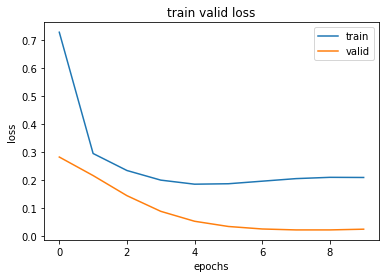

In [ ]:
model = GCN_RandFeatureOneHot(len(node_list), \
            edge_list =edge_index, \
            in_channels = 3,
            hidden_channels=32, \
            out_channels=64)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
loss_fn = torch.nn.BCEWithLogitsLoss()
epochs = 10

best_val_accu = final_test_accu = 0


train_loss = []
valid_loss = []
test_loss = []

for epoch in range(1, epochs + 1):
    loss = train_GCN_RandFeatureOneHot(model, all_edges_train_dict, node_feature_onehot,neg_edge_index, optimizer, loss_fn, train_mask)
    train_loss.append(loss.detach().numpy())
    valid_accu,v_loss = test2(model, all_edges_valid_dict,node_feature_onehot)
    valid_loss.append(v_loss.detach().numpy())
    scheduler.step()
    test_accu,t_loss = test2(model, all_edges_test_dict,node_feature_onehot)
    test_loss.append(t_loss.detach().numpy())
    if valid_accu > best_val_accu:
        best_val_accu = valid_accu
        final_test_accu = test_accu
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {valid_accu:.4f}, Test: {test_accu:.4f}')

plot_train_valid_loss(epochs,train_loss,valid_loss)

Epoch: 001, Loss: 1.6202, Val: 0.9588, Test: 0.9588
Epoch: 002, Loss: 0.8171, Val: 0.1008, Test: 0.1008
Epoch: 003, Loss: 0.4916, Val: 0.9086, Test: 0.9086
Epoch: 004, Loss: 0.4078, Val: 0.9762, Test: 0.9762
Epoch: 005, Loss: 0.3583, Val: 0.9918, Test: 0.9918
Epoch: 006, Loss: 0.3129, Val: 0.9988, Test: 0.9988
Epoch: 007, Loss: 0.2703, Val: 0.9996, Test: 0.9996
Epoch: 008, Loss: 0.2353, Val: 0.9999, Test: 0.9999
Epoch: 009, Loss: 0.2102, Val: 1.0000, Test: 1.0000
Epoch: 010, Loss: 0.1958, Val: 1.0000, Test: 1.0000


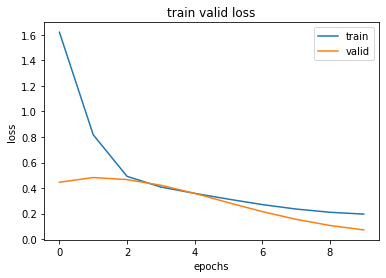

In [ ]:
model = GCN_RandFeatureOneHot(len(node_list), \
            edge_list =edge_index, \
            in_channels = 3,
            hidden_channels=32, \
            out_channels=32)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
loss_fn = torch.nn.BCEWithLogitsLoss()
epochs = 10

best_val_accu = final_test_accu = 0


train_loss = []
valid_loss = []
test_loss = []

for epoch in range(1, epochs + 1):
    loss = train_GCN_RandFeatureOneHot(model, all_edges_train_dict, node_feature_onehot,neg_edge_index, optimizer, loss_fn, train_mask)
    train_loss.append(loss.detach().numpy())
    valid_accu,v_loss = test2(model, all_edges_valid_dict,node_feature_onehot)
    valid_loss.append(v_loss.detach().numpy())
    scheduler.step()
    test_accu,t_loss = test2(model, all_edges_test_dict,node_feature_onehot)
    test_loss.append(t_loss.detach().numpy())
    if valid_accu > best_val_accu:
        best_val_accu = valid_accu
        final_test_accu = test_accu
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {valid_accu:.4f}, Test: {test_accu:.4f}')

plot_train_valid_loss(epochs,train_loss,valid_loss)

Epoch: 001, Loss: 2.1640, Val: 0.9869, Test: 0.9869
Epoch: 002, Loss: 0.9149, Val: 0.9751, Test: 0.9751
Epoch: 003, Loss: 0.4176, Val: 0.9808, Test: 0.9808
Epoch: 004, Loss: 0.3463, Val: 0.9911, Test: 0.9911
Epoch: 005, Loss: 0.3047, Val: 0.9981, Test: 0.9981
Epoch: 006, Loss: 0.2669, Val: 0.9996, Test: 0.9996
Epoch: 007, Loss: 0.2339, Val: 0.9999, Test: 0.9999
Epoch: 008, Loss: 0.2087, Val: 1.0000, Test: 1.0000
Epoch: 009, Loss: 0.1934, Val: 1.0000, Test: 1.0000
Epoch: 010, Loss: 0.1880, Val: 1.0000, Test: 1.0000
Epoch: 011, Loss: 0.1906, Val: 1.0000, Test: 1.0000
Epoch: 012, Loss: 0.1977, Val: 1.0000, Test: 1.0000
Epoch: 013, Loss: 0.2058, Val: 1.0000, Test: 1.0000
Epoch: 014, Loss: 0.2122, Val: 1.0000, Test: 1.0000
Epoch: 015, Loss: 0.2156, Val: 1.0000, Test: 1.0000
Epoch: 016, Loss: 0.2150, Val: 1.0000, Test: 1.0000
Epoch: 017, Loss: 0.2113, Val: 1.0000, Test: 1.0000
Epoch: 018, Loss: 0.2052, Val: 1.0000, Test: 1.0000
Epoch: 019, Loss: 0.1981, Val: 1.0000, Test: 1.0000
Epoch: 020, 

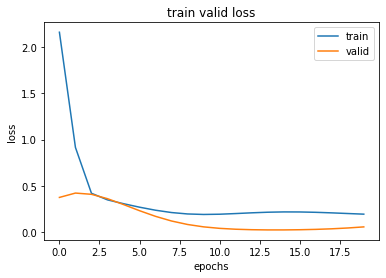

In [ ]:
model = GCN_RandFeatureOneHot(len(node_list), \
            edge_list =edge_index, \
            in_channels = 3,
            hidden_channels= 32, \
            out_channels=64)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
loss_fn = torch.nn.BCEWithLogitsLoss()
epochs = 20

best_val_accu = final_test_accu = 0


train_loss = []
valid_loss = []
test_loss = []

for epoch in range(1, epochs + 1):
    loss = train_GCN_RandFeatureOneHot(model, all_edges_train_dict, node_feature_onehot,neg_edge_index, optimizer, loss_fn, train_mask)
    train_loss.append(loss.detach().numpy())
    valid_accu,v_loss = test2(model, all_edges_valid_dict,node_feature_onehot)
    valid_loss.append(v_loss.detach().numpy())
    # scheduler.step()
    test_accu,t_loss = test2(model, all_edges_test_dict,node_feature_onehot)
    test_loss.append(t_loss.detach().numpy())
    if valid_accu > best_val_accu:
        best_val_accu = valid_accu
        final_test_accu = test_accu
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {valid_accu:.4f}, Test: {test_accu:.4f}')

plot_train_valid_loss(epochs,train_loss,valid_loss)

In [ ]:
final_model = model

In [ ]:
test2(final_model, all_edges_test_dict,node_feature_onehot)

(1.0, tensor(0.0431))

In [ ]:
test2(final_model, all_edges_test_dict,node_feature_onehot)

(1.0, tensor(0.0431))

In [ ]:
test2(final_model, all_edges_test_dict,node_feature_onehot)

(1.0, tensor(0.0431))

Epoch: 001, Loss: 0.3649, Val: 1.0000, Test: 1.0000
Epoch: 002, Loss: 0.2452, Val: 1.0000, Test: 1.0000
Epoch: 003, Loss: 0.2101, Val: 1.0000, Test: 1.0000


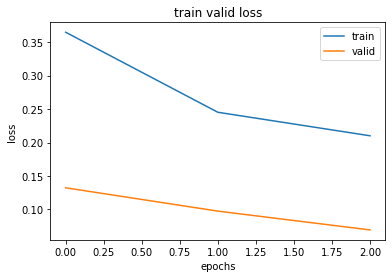

In [ ]:
model_test = GCN_RandFeatureOneHot(len(node_list), \
            edge_list =edge_index, \
            in_channels = 3,
            hidden_channels= 32, \
            out_channels=64)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
loss_fn = torch.nn.BCEWithLogitsLoss()
epochs = 3

best_val_accu = final_test_accu = 0


train_loss = []
valid_loss = []
test_loss = []

for epoch in range(1, epochs + 1):
    loss = train_GCN_RandFeatureOneHot(model, all_edges_train_dict, node_feature_onehot,neg_edge_index, optimizer, loss_fn, train_mask)
    train_loss.append(loss.detach().numpy())
    valid_accu,v_loss = test2(model, all_edges_valid_dict,node_feature_onehot)
    valid_loss.append(v_loss.detach().numpy())
    # scheduler.step()
    test_accu,t_loss = test2(model, all_edges_test_dict,node_feature_onehot)
    test_loss.append(t_loss.detach().numpy())
    if valid_accu > best_val_accu:
        best_val_accu = valid_accu
        final_test_accu = test_accu
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {valid_accu:.4f}, Test: {test_accu:.4f}')

plot_train_valid_loss(epochs,train_loss,valid_loss)

# Case study


In [ ]:
from sklearn.metrics import accuracy_score

@torch.no_grad()
def case_study(model, data,node_feature_onehot,test_data):
    model.eval()

    test_data = torch.tensor(test_data).to(device)

    all_edge = torch.tensor(np.column_stack((data["mm"], data["dd"],data["gg"],\
                             data["md"],data["mg"],data["dg"]))).to(device)

    out = model(all_edge,node_feature_onehot,_)

    similarity = compute_similarity(out,train_edge)
    y_pred =  []
    loss = loss_fn(similarity,torch.tensor([1]*len(train_edge[0])).float())

    for i in similarity:
      if i <0.5:
         y_pred.append(0)
      else:
          y_pred.append(1)
    return accuracy_score(y_pred, [1]*len(similarity)),loss

edge_index

In [ ]:
case_study_data = {}
case_study_data["leukemia"] = ["hsa-miR-17-5p",
"hsa-miR-153-3p",
"hsa-miR-126-3p",
"hsa-miR-520a-3p",
"hsa-miR-365a-3p",
"hsa-miR-300",
"hsa-miR-595",]


In [ ]:
case_study_data["acquired immunodeficiency syndrome"] = [
    "hsa-miR-34a-5p",
"hsa-miR-217",
"hsa-miR-17-5p",
"hsa-miR-34c-5p",
"hsa-miR-198",
]

In [ ]:
all_edges

array([[ 311,  311,  311, ..., 7342, 5467, 5467],
       [ 483,  710,  852, ..., 1204, 1131, 1148]])

In [ ]:
sig = torch.nn.Sigmoid()
sig(torch.tensor(2))

tensor(0.8808)

In [ ]:
out = model_test(torch.tensor(all_edges),node_feature_onehot,_)
for d, m_list in case_study_data.items():
  d_id = node2id[d]
  for m in m_list:
    m_id = node2id[m.lower()]
    test_edges = np.array([[m_id],[d_id]])
    if ([[m_id],[d_id]]) in np.transpose(all_edges) or ([[d_id],[m_id]]) in np.transpose(all_edges):
      print("edge exist")
    similarity = compute_similarity(out,test_edges)
    print("Disease: {} , miRNA: {}".format(d,m))
    print(sig(torch.tensor(similarity.detach().numpy()[0])))



Disease: leukemia , miRNA: hsa-miR-17-5p
tensor(0.9555)
Disease: leukemia , miRNA: hsa-miR-153-3p
tensor(0.9544)
Disease: leukemia , miRNA: hsa-miR-126-3p
tensor(0.9544)
Disease: leukemia , miRNA: hsa-miR-520a-3p
tensor(0.9533)
Disease: leukemia , miRNA: hsa-miR-365a-3p
tensor(0.9529)
Disease: leukemia , miRNA: hsa-miR-300
tensor(0.9573)
Disease: leukemia , miRNA: hsa-miR-595
tensor(0.9571)
Disease: acquired immunodeficiency syndrome , miRNA: hsa-miR-34a-5p
tensor(0.7586)
Disease: acquired immunodeficiency syndrome , miRNA: hsa-miR-217
tensor(0.7609)
Disease: acquired immunodeficiency syndrome , miRNA: hsa-miR-17-5p
tensor(0.7542)
Disease: acquired immunodeficiency syndrome , miRNA: hsa-miR-34c-5p
tensor(0.7601)
Disease: acquired immunodeficiency syndrome , miRNA: hsa-miR-198
tensor(0.7537)


<ipython-input-120-bb63936c1a18>:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ([[m_id],[d_id]]) in np.transpose(all_edges) or ([[d_id],[m_id]]) in np.transpose(all_edges):


In [ ]:
node_name

array(['hsa-mir-518e-3p', 'hsa-mir-647', 'hsa-mir-4465', ..., 'lrrn2',
       'nyap1', 'slc11a1'], dtype='<U39')

In [ ]:
node_name = np.array(list(node2id.keys()))
np.savetxt('/content/drive/MyDrive/FinalProject/Processed_Data/results/snode_name.txt',node_name,fmt='%s')

array([[ 0.14624387,  0.2641304 ,  0.29436398, ..., -0.27349657,
        -0.17756042, -0.18146738],
       [ 0.14675166,  0.26529768,  0.29492378, ..., -0.27437496,
        -0.17761624, -0.18240456],
       [ 0.14624387,  0.2641304 ,  0.29436398, ..., -0.27349657,
        -0.17756042, -0.18146738],
       ...,
       [ 0.21003965,  0.29909915,  0.40169775, ...,  0.00232743,
        -0.26256   ,  0.06970754],
       [ 0.21003965,  0.29909915,  0.40169775, ...,  0.00232743,
        -0.26256   ,  0.06970754],
       [ 0.21003965,  0.29909915,  0.40169775, ...,  0.00232743,
        -0.26256   ,  0.06970754]], dtype=float32)

In [ ]:
np.savetxt('/content/drive/MyDrive/FinalProject/Processed_Data/results/node_embeddings.txt',out.detach().numpy())

# embedding analysis


In [ ]:
proj_dir = os.path.join("/content/drive/MyDrive/FinalProject")
mm_p = os.path.join(proj_dir,"Processed_Data","m-m-12-11.csv")
mm_df = pd.read_csv(mm_p)
mm_df = mm_df.set_index("mirna")

In [ ]:
from math import sqrt, pow, exp
def squared_sum(x):
  """ return 3 rounded square rooted value """

  return round(sqrt(sum([a*a for a in x])),3)
def cos_similarity(x,y):
  """ return cosine similarity between two lists """

  numerator = sum(a*b for a,b in zip(x,y))
  denominator = squared_sum(x)*squared_sum(y)
  return round(numerator/float(denominator),3)

In [ ]:
m1

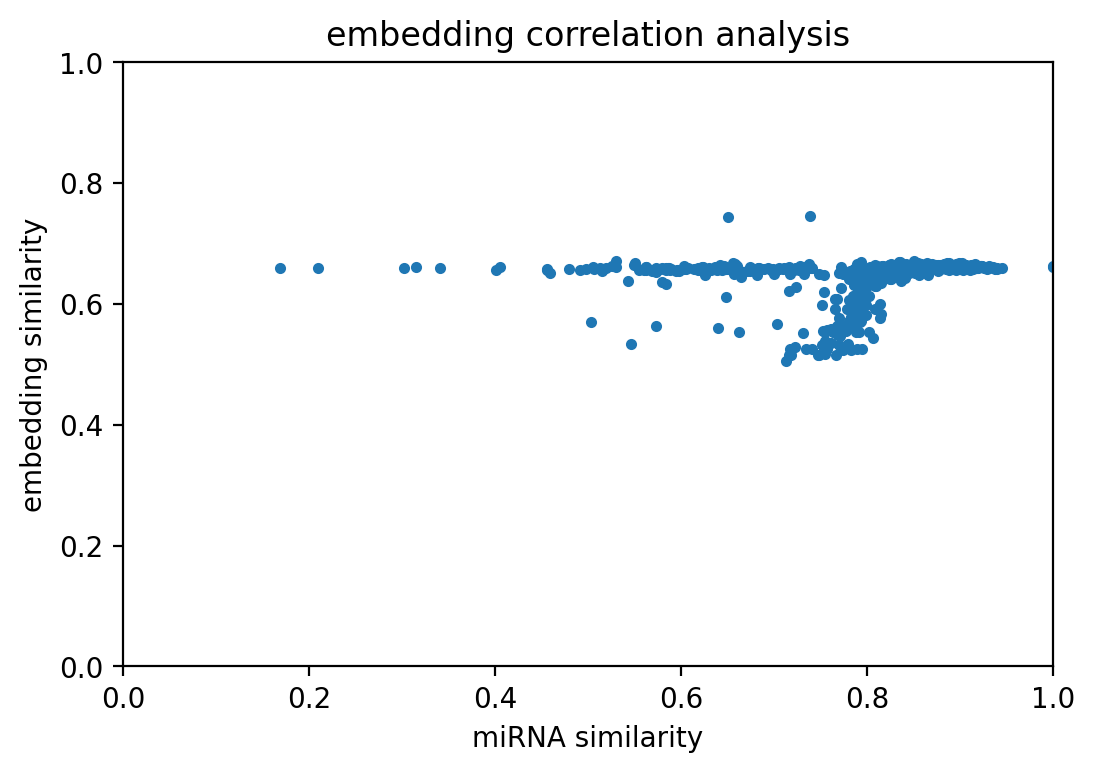

In [ ]:
# random select 50 miRNA pairs
mirnas=list(mm_df.index)
num = 700
pairs = []
mm_sim = []
mm_embed_sim = []
m1 = random.sample(mirnas, num)
m2 = random.sample(mirnas, num)

for n1, n2 in zip(m1,m2):
  rna1=node2id[str(n1)]
  rna2=node2id[str(n2)]
  mm_sim.append(mm_df[n1][n2])

  test_edges = np.array([[rna1],[rna2]])
  similarity = compute_similarity(out,test_edges)
  emb_score = sig(torch.tensor(similarity.detach().numpy()[0]))
  mm_embed_sim.append(emb_score)

fig, ax = plt.subplots(dpi=200)
plt.plot(mm_sim, mm_embed_sim, '.')

ax.set_ylabel('embedding similarity')
ax.set_xlabel('miRNA similarity')

plt.xlim(0,1)
plt.ylim(0,1)
# ax.xaxis.set_major_locator(loc)
# ax.xaxis.set_major_formatter(formatter)
# ax.xaxis.set_tick_params(rotation=30, labelsize=10)
plt.title("embedding correlation analysis")

plt.show()

In [ ]:
dd_p = os.path.join(proj_dir,"Processed_Data","d-d-mtx-12-11.csv")
dd_name_p = os.path.join(proj_dir,"Processed_Data","d-d-name-12-11.csv")

dd_df = pd.read_csv(dd_p)
dd_name_df = pd.read_csv(dd_name_p)

dd_name_df_list = dd_name_df["1"].tolist()
dd_df = dd_df.iloc[: , 1:]
dd_df.index = dd_name_df_list
dd_df.columns = dd_name_df_list

In [ ]:
dd_df

,pituitary adenoma,acquired immunodeficiency syndrome,adenocarcinoma,adenoma,renal carcinoma,alopecia,alzheimers disease,amyotrophic lateral sclerosis,anxiety disorder,aortic aneurysm,...,psychotic disorder,pulmonary fibrosis,retinal degeneration,retinal vascular disease,sarcoma,scleroderma,sjogrens syndrome,stomach disease,vascular disease,vitiligo
pituitary adenoma,1.000000,0.059278,0.139920,0.325390,0.22347,0.052258,0.101910,0.083206,0.078028,0.064809,...,0.064989,0.063842,0.059612,0.016834,0.134820,0.060006,0.063959,0.080069,0.073067,0.071386
acquired immunodeficiency syndrome,0.059278,1.000000,0.146140,0.146420,0.13494,0.074642,0.143780,0.142150,0.125540,0.157530,...,0.146760,0.208250,0.127270,0.067335,0.165050,0.213070,0.238100,0.146830,0.182760,0.215000
adenocarcinoma,0.139920,0.146140,1.000000,0.502410,0.43804,0.052232,0.304840,0.254770,0.177320,0.132860,...,0.151990,0.221810,0.141260,0.048486,0.369650,0.247730,0.127550,0.093578,0.221990,0.162150
adenoma,0.325390,0.146420,0.502410,1.000000,0.28956,0.055708,0.276760,0.240240,0.193340,0.147040,...,0.159200,0.212640,0.145500,0.047612,0.374450,0.239060,0.123770,0.094512,0.226480,0.161650
renal carcinoma,0.223470,0.134940,0.438040,0.289560,1.00000,0.086364,0.151990,0.149130,0.152890,0.158640,...,0.144520,0.179600,0.130450,0.080590,0.221240,0.176700,0.129580,0.115100,0.171820,0.131780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
scleroderma,0.060006,0.213070,0.247730,0.239060,0.17670,0.150600,0.242640,0.236930,0.171740,0.170050,...,0.158780,0.292010,0.144270,0.056860,0.264640,1.000000,0.274730,0.119120,0.257140,0.335250
sjogrens syndrome,0.063959,0.238100,0.127550,0.123770,0.12958,0.074716,0.127150,0.131240,0.109920,0.133120,...,0.128790,0.193330,0.130940,0.080031,0.142310,0.274730,1.000000,0.122130,0.162290,0.225500
stomach disease,0.080069,0.146830,0.093578,0.094512,0.11510,0.059459,0.086569,0.084738,0.088906,0.116090,...,0.087244,0.129560,0.066934,0.053650,0.099354,0.119120,0.122130,1.000000,0.117290,0.147590
vascular disease,0.073067,0.182760,0.221990,0.226480,0.17182,0.048241,0.244620,0.227790,0.184720,0.409830,...,0.158700,0.259490,0.150880,0.063853,0.233520,0.257140,0.162290,0.117290,1.000000,0.200230


In [ ]:
gg_p = os.path.join(proj_dir,"Processed_Data","gene_gene_similarity.txt")
gg_df = pd.read_csv(gg_p,sep = '\t',header = None)
gg_df

,0,1,2
0,CFH,CFTR,0.189667
1,CFH,RAD52,0.315333
2,CFH,WNT16,0.399000
3,CFH,SARM1,0.292333
4,CFH,HSPB6,0.323000
...,...,...,...
843046,UHRF1,PCGF2,0.599333
843047,UHRF1,HOMEZ,0.495333
843048,PIP4K2B,PCGF2,0.293667
843049,PIP4K2B,HOMEZ,0.333000


In [ ]:
a = []
a.append(gg_df.iloc[2][2])

[341278, 89491, 41948, 456789, 410711, 666133, 353417, 394459, 502884, 179017, 97759, 526687, 584379, 443930, 201431, 759442, 621267, 237355, 598706, 559985, 588599, 404132, 409035, 588024, 329408, 156001, 691173, 613415, 571768, 158241, 595113, 400230, 135957, 225681, 441969, 616215, 837061, 637104, 842715, 172211, 507382, 185732, 211366, 509858, 526989, 819503, 45798, 350640, 33914, 37643]
[341278, 89491, 41948, 456789, 410711, 666133, 353417, 394459, 502884, 179017, 97759, 526687, 584379, 443930, 201431, 759442, 621267, 237355, 598706, 559985, 588599, 404132, 409035, 588024, 329408, 156001, 691173, 613415, 571768, 158241, 595113, 400230, 135957, 225681, 441969, 616215, 837061, 637104, 842715, 172211, 507382, 185732, 211366, 509858, 526989, 819503, 45798, 350640, 33914, 37643]
[341278, 89491, 41948, 456789, 410711, 666133, 353417, 394459, 502884, 179017, 97759, 526687, 584379, 443930, 201431, 759442, 621267, 237355, 598706, 559985, 588599, 404132, 409035, 588024, 329408, 156001, 6911

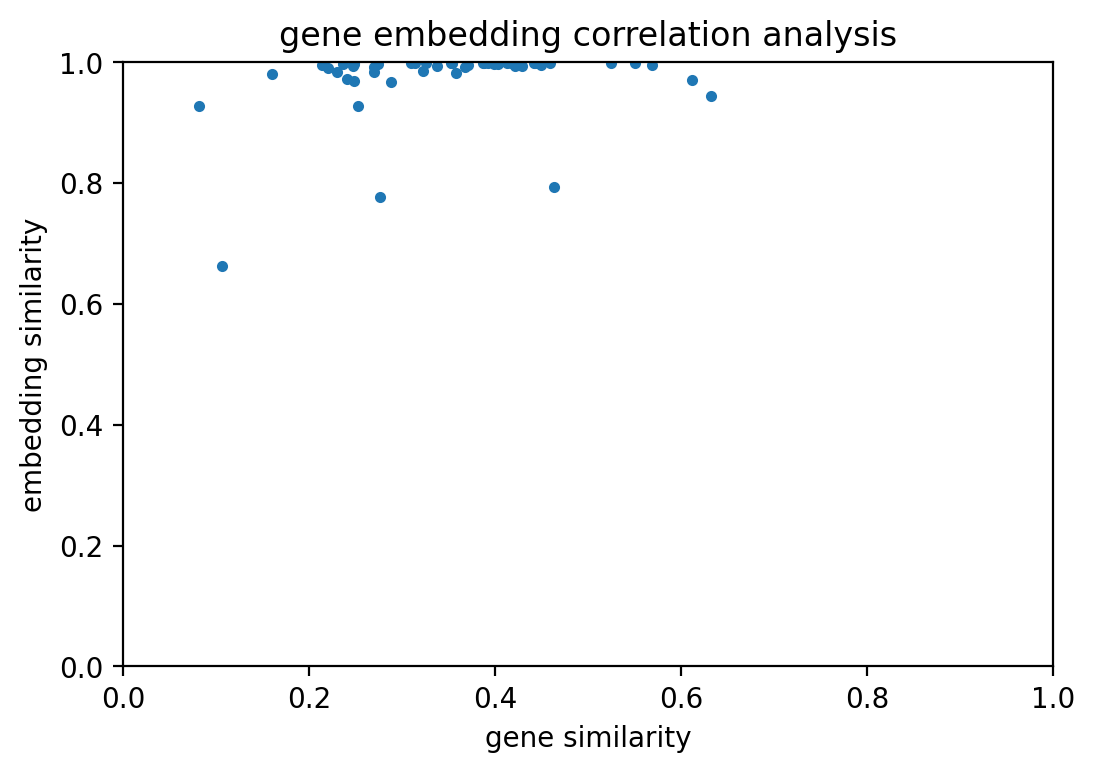

In [ ]:

# random select 50 miRNA pairs
mirnas=list(gg_df.index)
num = 50
pairs = []
mm_sim = []
mm_embed_sim = []
m1 = random.sample(mirnas, num)

for i in m1:
  print(m1)
  mm_sim.append(gg_df.iloc[i][2])
  rna1 = node2id[gg_df.iloc[i][0].lower()]
  rna2 = node2id[gg_df.iloc[i][1].lower()]
  test_edges = np.array([[rna1],[rna2]])
  similarity = compute_similarity(out,test_edges)
  emb_score = sig(torch.tensor(similarity.detach().numpy()[0]))
  mm_embed_sim.append(emb_score)

fig, ax = plt.subplots(dpi=200)
plt.plot(mm_sim, mm_embed_sim, '.')

ax.set_ylabel('embedding similarity')
ax.set_xlabel('gene similarity')
plt.title("gene embedding correlation analysis")

plt.xlim(0,1)
plt.ylim(0,1)
# ax.xaxis.set_major_locator(loc)
# ax.xaxis.set_major_formatter(formatter)
# ax.xaxis.set_tick_params(rotation=30, labelsize=10)

plt.show()

In [ ]:
# random select 50 miRNA pairs
mirnas=list(dd_df.index)
num = 50
pairs = []
mm_sim = []
mm_embed_sim = []
m1 = random.sample(mirnas, num)
m2 = random.sample(mirnas, num)

for n1, n2 in zip(m1,m2):
  rna1=node2id[str(n1)]
  rna2=node2id[str(n2)]
  mm_sim.append(dd_df[n1][n2])

  test_edges = np.array([[rna1],[rna2]])
  similarity = compute_similarity(out,test_edges)
  emb_score = sig(torch.tensor(similarity.detach().numpy()[0]))
  mm_embed_sim.append(emb_score)

fig, ax = plt.subplots(dpi=200)
plt.plot(mm_sim, mm_embed_sim, '.')

ax.set_ylabel('embedding similarity')
ax.set_xlabel('disease similarity')
plt.title("disease embedding correlation analysis")

plt.xlim(0,1)
plt.ylim(0,1)
# ax.xaxis.set_major_locator(loc)
# ax.xaxis.set_major_formatter(formatter)
# ax.xaxis.set_tick_params(rotation=30, labelsize=10)

plt.show()

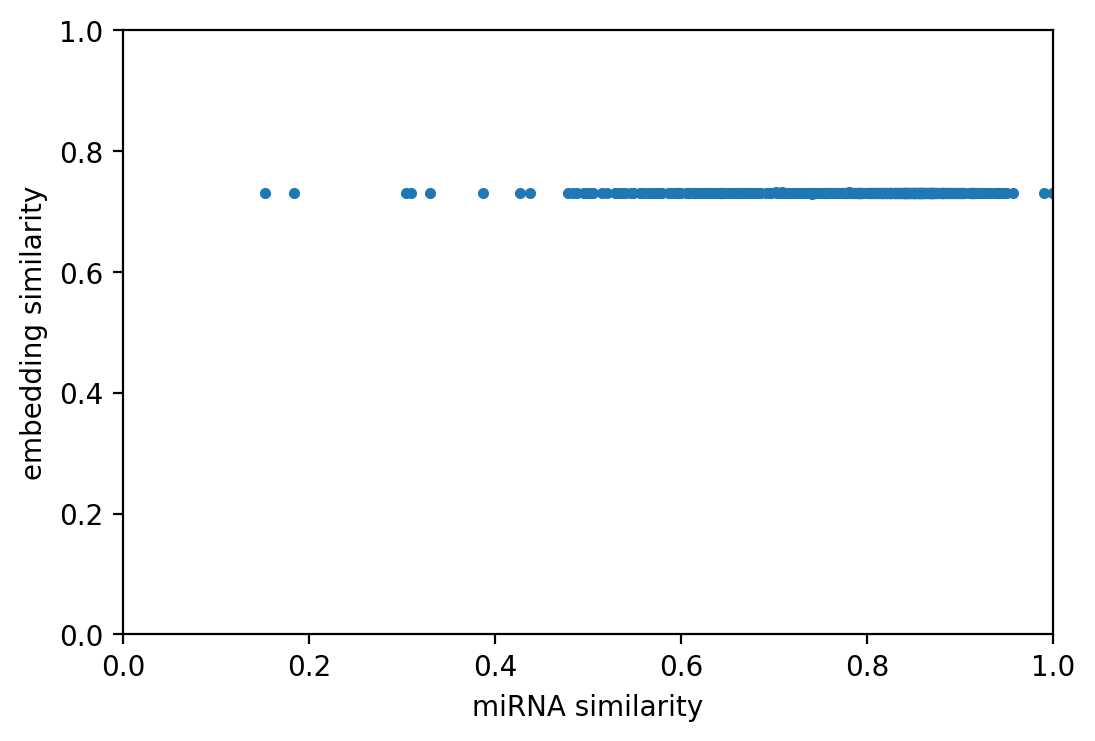

In [ ]:
# random select 50 miRNA pairs
mirnas=list(mm_df.index)
num = 700
pairs = []
mm_sim = []
mm_embed_sim = []
m1 = random.sample(mirnas, num)
m2 = random.sample(mirnas, num)

for n1, n2 in zip(m1,m2):
  rna1=node2id[str(n1)]
  rna2=node2id[str(n2)]
  mm_sim.append(mm_df[n1][n2])

  test_edges = np.array([[rna1],[rna2]])
  similarity = cos_similarity(out[rna1].detach().numpy(),out[rna2].detach().numpy(),)
  emb_score = sig(torch.tensor(similarity))
  mm_embed_sim.append(emb_score)

fig, ax = plt.subplots(dpi=200)
plt.plot(mm_sim, mm_embed_sim, '.')

ax.set_ylabel('embedding similarity')
ax.set_xlabel('miRNA similarity')

plt.xlim(0,1)
plt.ylim(0,1)
# ax.xaxis.set_major_locator(loc)
# ax.xaxis.set_major_formatter(formatter)
# ax.xaxis.set_tick_params(rotation=30, labelsize=10)

plt.show()

Index(['hsa-let-7a-2-3p', 'hsa-let-7b-3p', 'hsa-let-7b-5p', 'hsa-let-7c-3p',
       'hsa-let-7c-5p', 'hsa-let-7d-3p', 'hsa-let-7d-5p', 'hsa-let-7e-3p',
       'hsa-let-7e-5p', 'hsa-let-7f-1-3p',
       ...
       'hsa-mir-95-3p', 'hsa-mir-95-5p', 'hsa-mir-96-3p', 'hsa-mir-96-5p',
       'hsa-mir-98-3p', 'hsa-mir-98-5p', 'hsa-mir-99a-3p', 'hsa-mir-99a-5p',
       'hsa-mir-99b-3p', 'hsa-mir-99b-5p'],
      dtype='object', name='mirna', length=739)

# Legacy

In [ ]:
model = GCN_RandFeatureOneHot(len(node_list), \
            edge_list =edge_index, \
            in_channels = 3,
            hidden_channels= 32, \
            out_channels=64)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
loss_fn = torch.nn.BCEWithLogitsLoss()
epochs = 20

best_val_accu = final_test_accu = 0


train_loss = []
valid_loss = []
test_loss = []

for epoch in range(1, epochs + 1):
    loss = train_GCN_RandFeatureOneHot(model, all_edges_train_dict, node_feature_onehot,neg_edge_index, optimizer, loss_fn, train_mask)
    train_loss.append(loss.detach().numpy())
    valid_accu,v_loss = test2(model, all_edges_valid_dict,node_feature_onehot)
    valid_loss.append(v_loss.detach().numpy())
    # scheduler.step()
    test_accu,t_loss = test2(model, all_edges_test_dict,node_feature_onehot)
    test_loss.append(t_loss.detach().numpy())
    if valid_accu > best_val_accu:
        best_val_accu = valid_accu
        final_test_accu = test_accu
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {valid_accu:.4f}, Test: {test_accu:.4f}')

plot_train_valid_loss(epochs,train_loss,valid_loss)

In [ ]:
model = GCN_RandFeatureOneHot(len(node_list), \
            edge_list =edge_index, \
            in_channels = 3,
            hidden_channels=32, \
            out_channels=64)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.1)

from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
loss_fn = torch.nn.BCEWithLogitsLoss()
epochs = 10

best_val_accu = final_test_accu = 0
for epoch in range(1, epochs + 1):
    loss = train_GCN_RandFeatureOneHot(model, all_edges_train_dict, node_feature_onehot,neg_edge_index, optimizer, loss_fn, train_mask)
    valid_accu = test2(model, all_edges_valid_dict,node_feature_onehot)
    scheduler.step()

    test_accu = test2(model, all_edges_test_dict,node_feature_onehot)
    if valid_accu > best_val_accu:
        best_val_accu = valid_accu
        final_test_accu = test_accu
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {valid_accu:.4f}, Test: {test_accu:.4f}')

TypeError: ignored

In [ ]:
model2 = GCN_RandFeatureOneHot(len(node_list), \
            edge_list =edge_index, \
            in_channels = 3,
            hidden_channels=128, \
            out_channels=64)

optimizer = torch.optim.Adam(params=model2.parameters(), lr=0.01)
loss_fn = torch.nn.BCEWithLogitsLoss()
epochs = 50

best_val_accu = final_test_accu = 0

for epoch in range(1, epochs + 1):
    loss = train_GCN_RandFeatureOneHot(model2, all_edges_train_dict, node_feature_onehot,neg_edge_index, optimizer, loss_fn, train_mask)
    valid_accu = test2(model2, all_edges_valid_dict,node_feature_onehot)

    test_accu = test2(model2, all_edges_test_dict,node_feature_onehot)
    if valid_accu > best_val_accu:
        best_val_accu = valid_accu
        final_test_accu = test_accu
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {valid_accu:.4f}, Test: {test_accu:.4f}')

Epoch: 001, Loss: 0.6804, Val: 0.0000, Test: 0.0000
Epoch: 002, Loss: 0.6804, Val: 0.9895, Test: 0.9895
Epoch: 003, Loss: 0.6967, Val: 0.0000, Test: 0.0000
Epoch: 004, Loss: 0.6764, Val: 0.0000, Test: 0.0000
Epoch: 005, Loss: 0.6807, Val: 0.0000, Test: 0.0000
Epoch: 006, Loss: 0.6825, Val: 0.0000, Test: 0.0000
Epoch: 007, Loss: 0.6806, Val: 0.0000, Test: 0.0000
Epoch: 008, Loss: 0.6774, Val: 0.0000, Test: 0.0000
Epoch: 009, Loss: 0.6770, Val: 0.9487, Test: 0.9487
Epoch: 010, Loss: 0.6799, Val: 0.9132, Test: 0.9132
Epoch: 011, Loss: 0.6791, Val: 0.0000, Test: 0.0000
Epoch: 012, Loss: 0.6769, Val: 0.0000, Test: 0.0000
Epoch: 013, Loss: 0.6766, Val: 0.0000, Test: 0.0000
Epoch: 014, Loss: 0.6775, Val: 0.0000, Test: 0.0000
Epoch: 015, Loss: 0.6782, Val: 0.0000, Test: 0.0000
Epoch: 016, Loss: 0.6782, Val: 0.0000, Test: 0.0000
Epoch: 017, Loss: 0.6775, Val: 0.0000, Test: 0.0000
Epoch: 018, Loss: 0.6767, Val: 0.0000, Test: 0.0000
Epoch: 019, Loss: 0.6763, Val: 0.0000, Test: 0.0000
Epoch: 020, 

In [ ]:
model = GCN_RandFeatureOneHot(len(node_list), \
            edge_list =edge_index, \
            in_channels = 3,
            hidden_channels=128, \
            out_channels=64)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
loss_fn = torch.nn.BCEWithLogitsLoss()
epochs = 10

best_val_accu = final_test_accu = 0

for epoch in range(1, epochs + 1):
    loss = train_GCN_RandFeatureOneHot(model, all_edges_train_dict, node_feature_onehot,neg_edge_index, optimizer, loss_fn, train_mask)

    valid_accu = test2(model, edge_index_valid,node_feature_onehot)

    test_accu = test2(model, edge_index_test,node_feature_onehot)
    if valid_accu > best_val_accu:
        best_val_accu = valid_accu
        final_test_accu = test_accu
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {valid_accu:.4f}, Test: {test_accu:.4f}')

In [ ]:
test(model, edge_index_valid)

100%|██████████| 69325/69325 [00:06<00:00, 11360.66it/s]


1.0

In [ ]:
from sklearn.metrics import accuracy_score

@torch.no_grad()
def test(model, data):
    model.eval()
    out = model(data)

    data = data["md"]
    data = np.transpose(data)
    y_pred = []
    for idx, pair in enumerate(tqdm(data)):
      pair_embed = (out[pair[0]],out[pair[1]])
      y_pred.append(model.classifier1(pair_embed))
    y_pred = [1 if y>0.5 else 0 for y in y_pred]

    return accuracy_score([1]*len(y_pred), y_pred)
epochs = 50

best_val_accu = final_test_accu = 0
for epoch in range(1, epochs + 1):
    loss = train2(model, edge_index_train, neg_edge_index, optimizer, loss_fn)
    valid_accu = test(model, edge_index_valid)
    test_accu = test(model, edge_index_test)
    if valid_accu > best_val_accu:
        best_val_accu = valid_accu
        final_test_accu = test_accu
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {valid_accu:.4f}, Test: {test_accu:.4f}')

TypeError: ignored

In [ ]:
10758 in edge_index["gg"]

In [ ]:
10758 in node_list

In [ ]:
import numpy.ma as ma
a = [1,2,3,4,5]
mask = [1,0,0,1,1]
ma.masked_array(a,mask)

In [ ]:
t = torch.Tensor(a)
t1 = torch.Tensor(mask)
torch.mul(t, t1)

In [ ]:
from torch_geometric.datasets import OGB_MAG

dataset = OGB_MAG(root='./data', preprocess='metapath2vec')
data = dataset[0]

Extracting data/mag/raw/mag.zip
Extracting data/mag/raw/mag_metapath2vec_emb.zip
Processing...
Done!
